### 1. Setup

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline

import os
# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# prophet by Facebook
from fbprophet import Prophet

# AI with fastai2
from fastai.basics import *


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# function KeepClicking(){
#    console.log("Clicking");
#    document.querySelector("colab-toolbar-button#connect").click()
# }setInterval(KeepClicking,60000)

### 1.2 Get Data

In [ ]:
path_main = Path('/content/drive/MyDrive/Colab Notebooks/kaggle/rossmann')
path_main

PosixPath('/content/drive/MyDrive/Colab Notebooks/kaggle/rossmann')

In [ ]:
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Colab Notebooks/kaggle/rossmann'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/kaggle/rossmann/train.csv", 
                    parse_dates=True, low_memory=False, index_col='Date')

store = pd.read_csv(path_main/'store.csv', low_memory=False,)
train.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

In [ ]:
print(f'the total: {train.shape}')
train.head()

the total: (1017209, 8)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [ ]:
print(f'data from : {train.index.min()} to {train.index.max()}')

data from : 2013-01-01 00:00:00 to 2015-07-31 00:00:00


In [ ]:
# Data extraction from datetime index
train["Day"] = train.index.day
train["Month"] = train.index.month
train["Year"] = train.index.year
train["WeekOfYear"] = train.index.weekofyear

train['SalesPerCustomer'] = train.Sales / train.Customers
train.SalesPerCustomer.describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalesPerCustomer, dtype: float64

### 2.2 EDA

#### 2.2.1 Sales Data (train.csv file) 

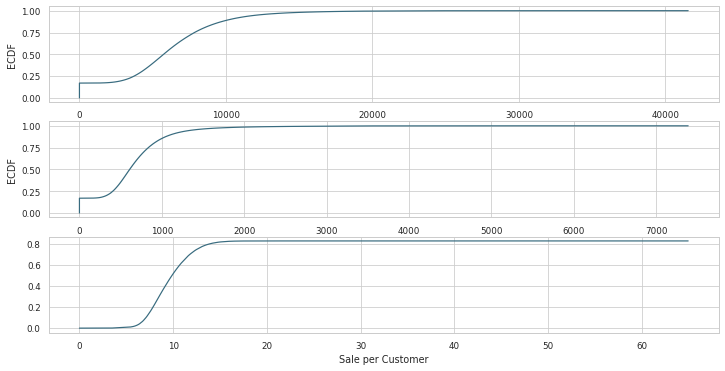

In [ ]:
sns.set(style = 'whitegrid')
sns.set_context('paper')
sns.set_palette('Blues')
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 6))


# exponential cumulative distribution function
plt.subplot(311)
cdf = ECDF(train.Sales)
plt.plot(cdf.x, cdf.y, label = 'statsmodels', color=c)
plt.xlabel('Sales'); plt.ylabel('ECDF')

plt.subplot(312)
cdf = ECDF(train.Customers)
plt.plot(cdf.x, cdf.y, label = 'statsmodels', color=c)
plt.xlabel('Customer'); plt.ylabel('ECDF')

plt.subplot(313)
cdf = ECDF(train['SalesPerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sale per Customer');


In [ ]:
# First Plot: 20% of rows no Sales and second plot shows also 20% of time no Customers



#### 2.2 Missing Values - check and replace


In [ ]:

train[(train.Open == 0) & (train.Sales ==0)].head()
print(f'numbers of data entries with no Sales and closed {train[(train.Open == 0) & (train.Sales ==0)].shape}')

numbers of data entries with no Sales and closed (172817, 13)


In [ ]:
# drop mising values to avoid bias in forecast

print('delete stores and days with no sales')

train  = train[(train.Open != 0) & (train.Sales != 0)]

print(f'length of new data entries {train.shape}')

delete stores and days with no sales
length of new data entries (844338, 13)


In [ ]:
#### 2.2.2 Store Data

In [ ]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


- Store: a unique Id
- StoreType: 4 different store models: a, b, c, d
- Assortment: assortment level: a = basic, b = extra, c = extended
- CompetitionDistance: distance in meters to the nearest competitor
- CompetitionOpenSince[Month/Year]: 
- Promo2: Promo2 is a continuing a promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week]: describes the year and calendar week when the store started participating in Promo2
- PromoInterval: "Feb,May,Aug,Nov" means each round starts in February, May, 
August, November of any given year for that store

In [ ]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [ ]:
# check missing values for each column
# Competition Distance
store[pd.isnull(store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [ ]:
# 3 fill withmedian since no particular reason detectable why this happened. probably just error on input
store.CompetitionDistance.fillna(store.CompetitionDistance.median(), inplace=True)

In [ ]:
# 2. Promo2SinceWeek
_ = store[pd.isnull(store.Promo2SinceWeek)]
_.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN


In [ ]:
# same as above, Promo2SinceWeek, CompetitionOpenSinceMonth and CompetitionOpenSinceYear

# replace with 0
store.fillna(0, inplace=True)

#### 2.2.3 Join datasets

In [ ]:
train_store = pd.merge(train, store, how='inner', on="Store")
print(f'In total {train_store.shape} data entries')
train_store.head()

In total (844338, 22) data entries


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,WeekOfYear,SalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,31,7,2015,31,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,30,7,2015,31,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,29,7,2015,31,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,28,7,2015,31,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,27,7,2015,31,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


#### 2.2.4 Store Type - Sales Correlations

In [ ]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


In [ ]:
train_store.groupby('StoreType')['Sales', 'Customers'].sum()

,Sales,Customers
StoreType,,
a,3165334859,363541431
b,159231395,31465616
c,783221426,92129705
d,1765392943,156904995


In [ ]:
train_store.groupby('StoreType')['SalesPerCustomer'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,8.846296,1.690913,3.635389,7.611945,8.631363,9.899438,29.877551
b,15560.0,5.133427,1.253988,2.749075,4.039561,4.987022,6.108760,9.203528
c,112968.0,8.626227,1.694325,3.382542,7.416985,8.424736,9.643063,64.957854
d,258768.0,11.277862,1.990706,4.881279,9.873309,11.194977,12.560328,57.614983


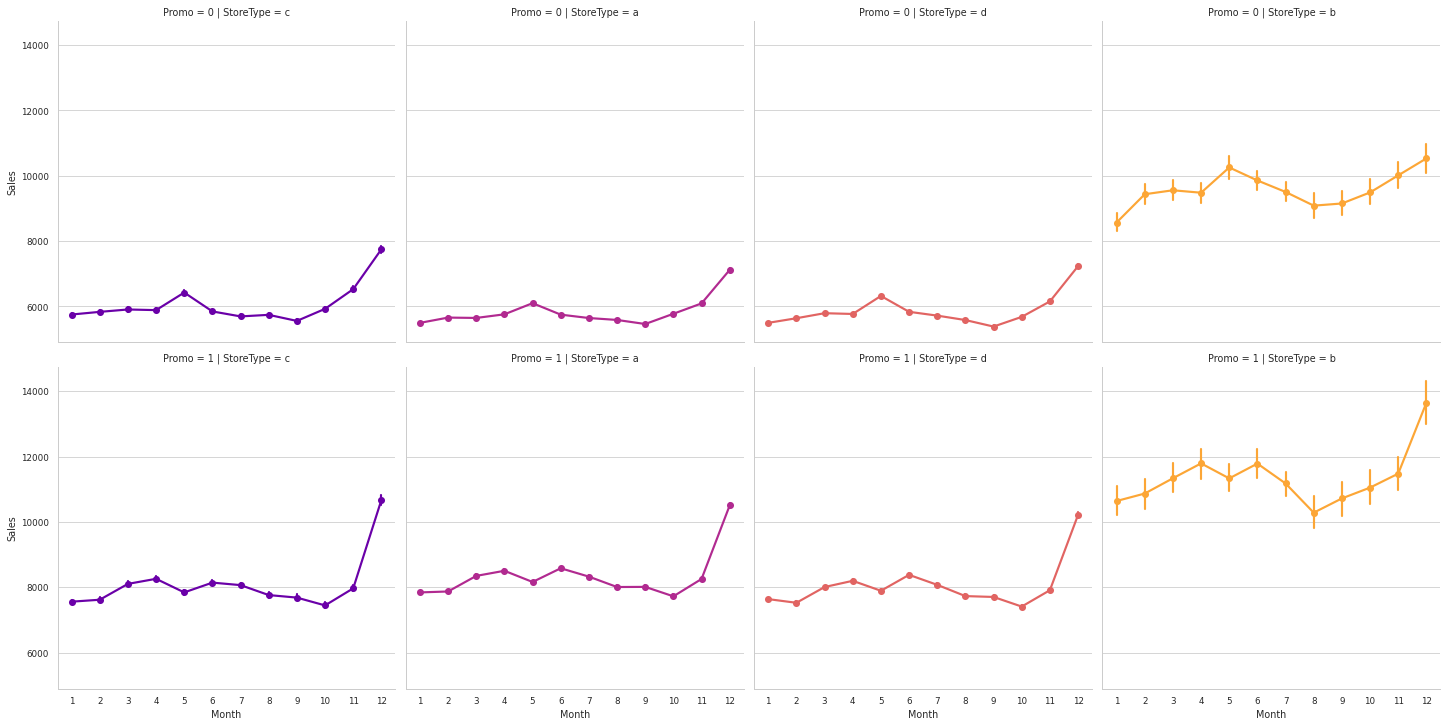

In [ ]:
sns.factorplot(data= train_store, x='Month', y='Sales',
               col = "StoreType",
               palette='plasma',
               hue='StoreType',
               row='Promo', color= c)

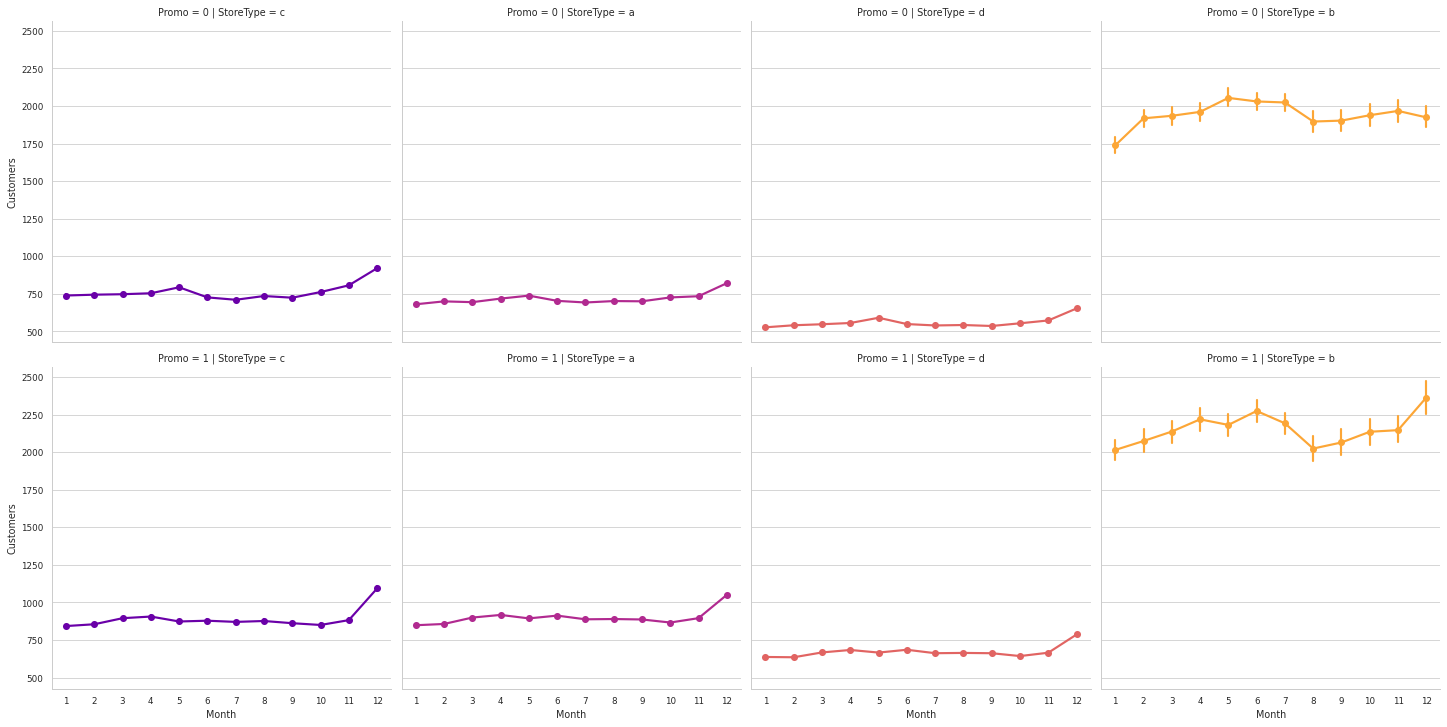

In [ ]:
sns.factorplot(data=train_store, x='Month', y="Customers",
               col="StoreType",
               palette= 'plasma',
               hue = 'StoreType',
               row="Promo",
               color=c)

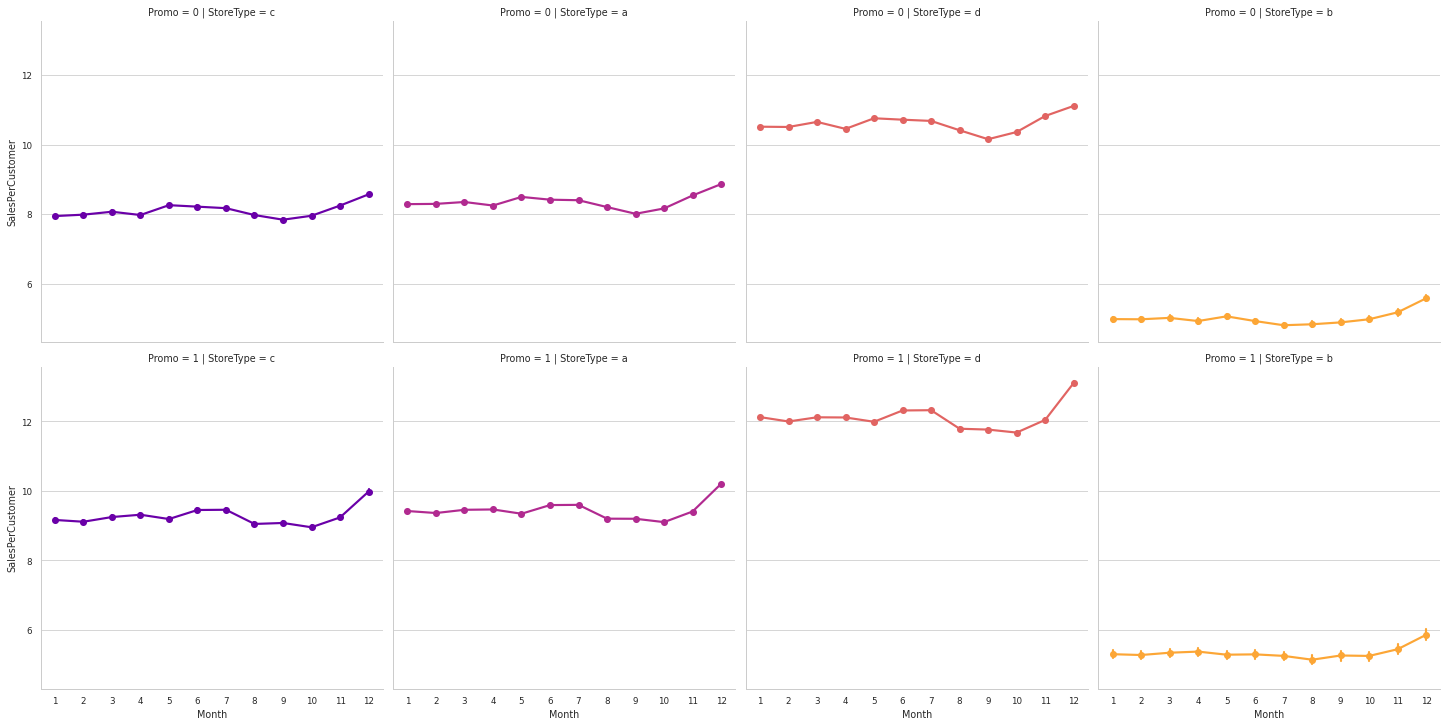

In [ ]:
sns.factorplot(data=train_store, x='Month', y='SalesPerCustomer',
               col='StoreType',
               palette = 'plasma',
               hue='StoreType',
               row='Promo',
               color=c)

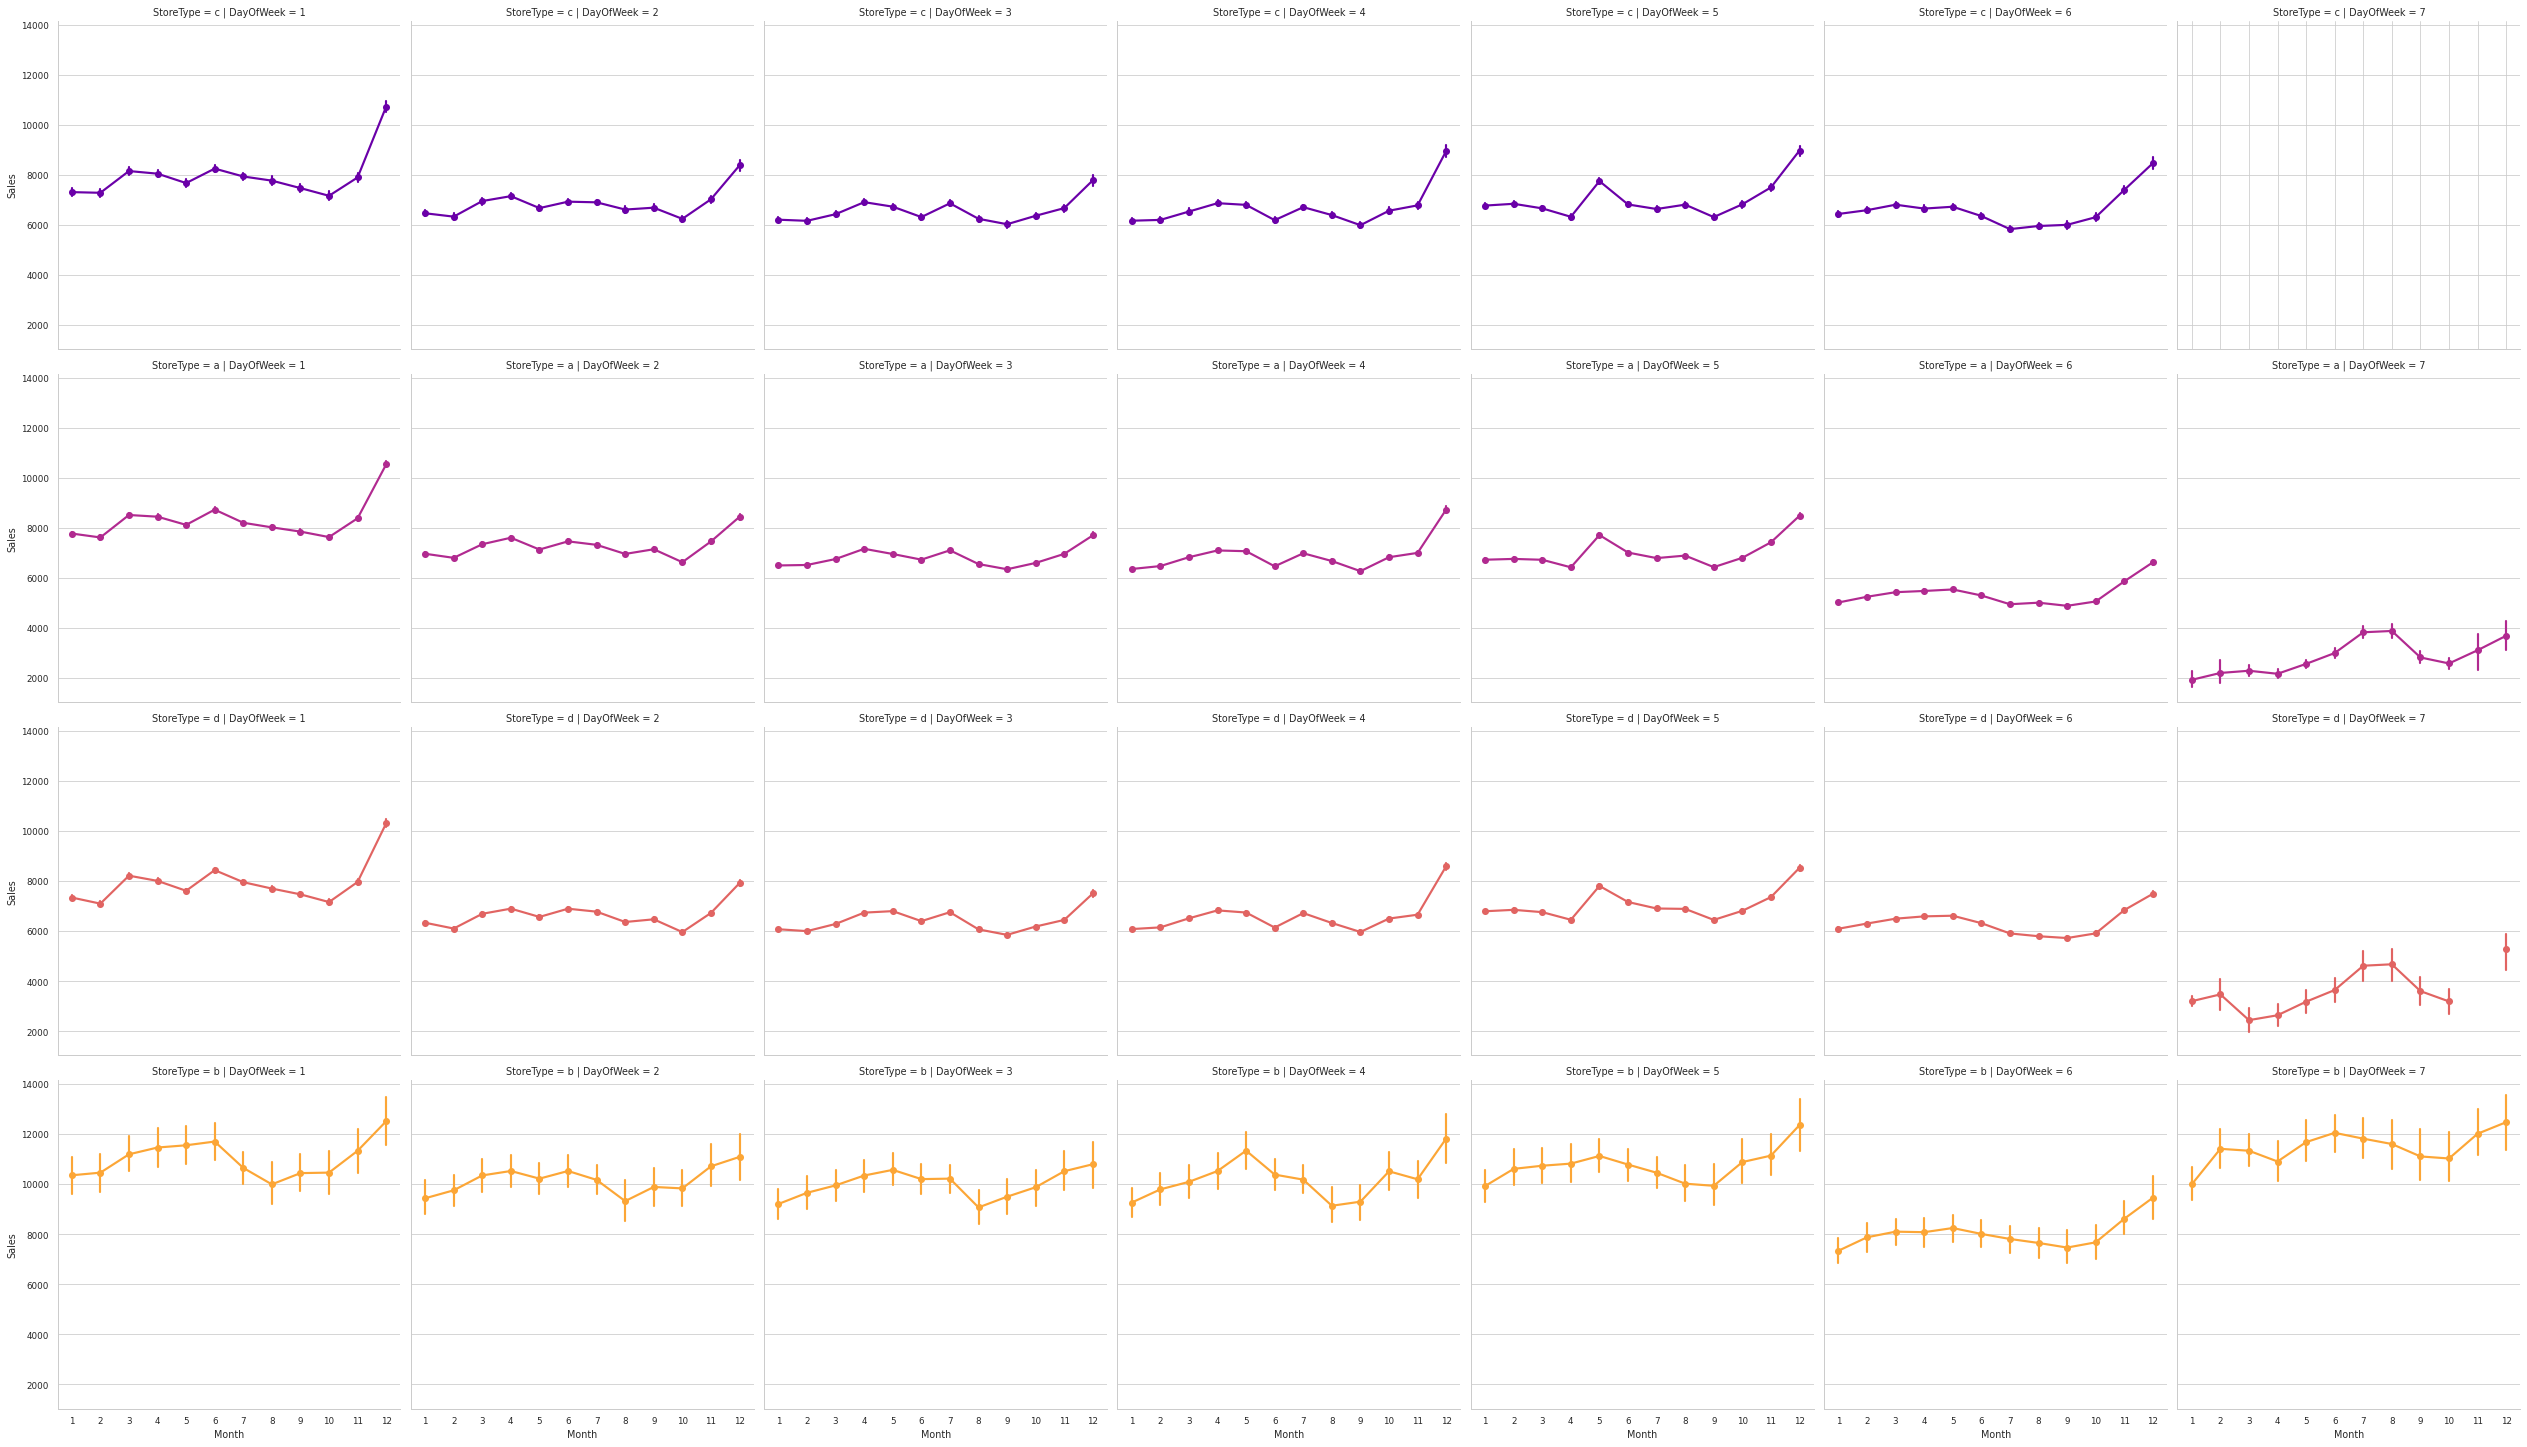

In [ ]:
sns.factorplot(data=train_store, x='Month', y='Sales',
               col='DayOfWeek',
               palette = 'plasma',
               hue='StoreType',
               row='StoreType',
               color=c)

In [ ]:
# stores open on sunday ?
train_store[(train_store.Open ==1) & (train_store.DayOfWeek == 7)]['Store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,  433,  453,  494,  512,  524,  530,  562,
        578,  676,  682,  732,  733,  769,  863,  867,  877,  931,  948, 1045, 1081, 1097, 1099])

#### 2.2.5 Correlation Matrix

In [ ]:
import statsmodels.api as sm

hie_data = sm.datasets.randhie.load_pandas()


In [ ]:
# pandas .corr()
# or np.corrcoef(df.T)
corr_matrix = train_store.corr()


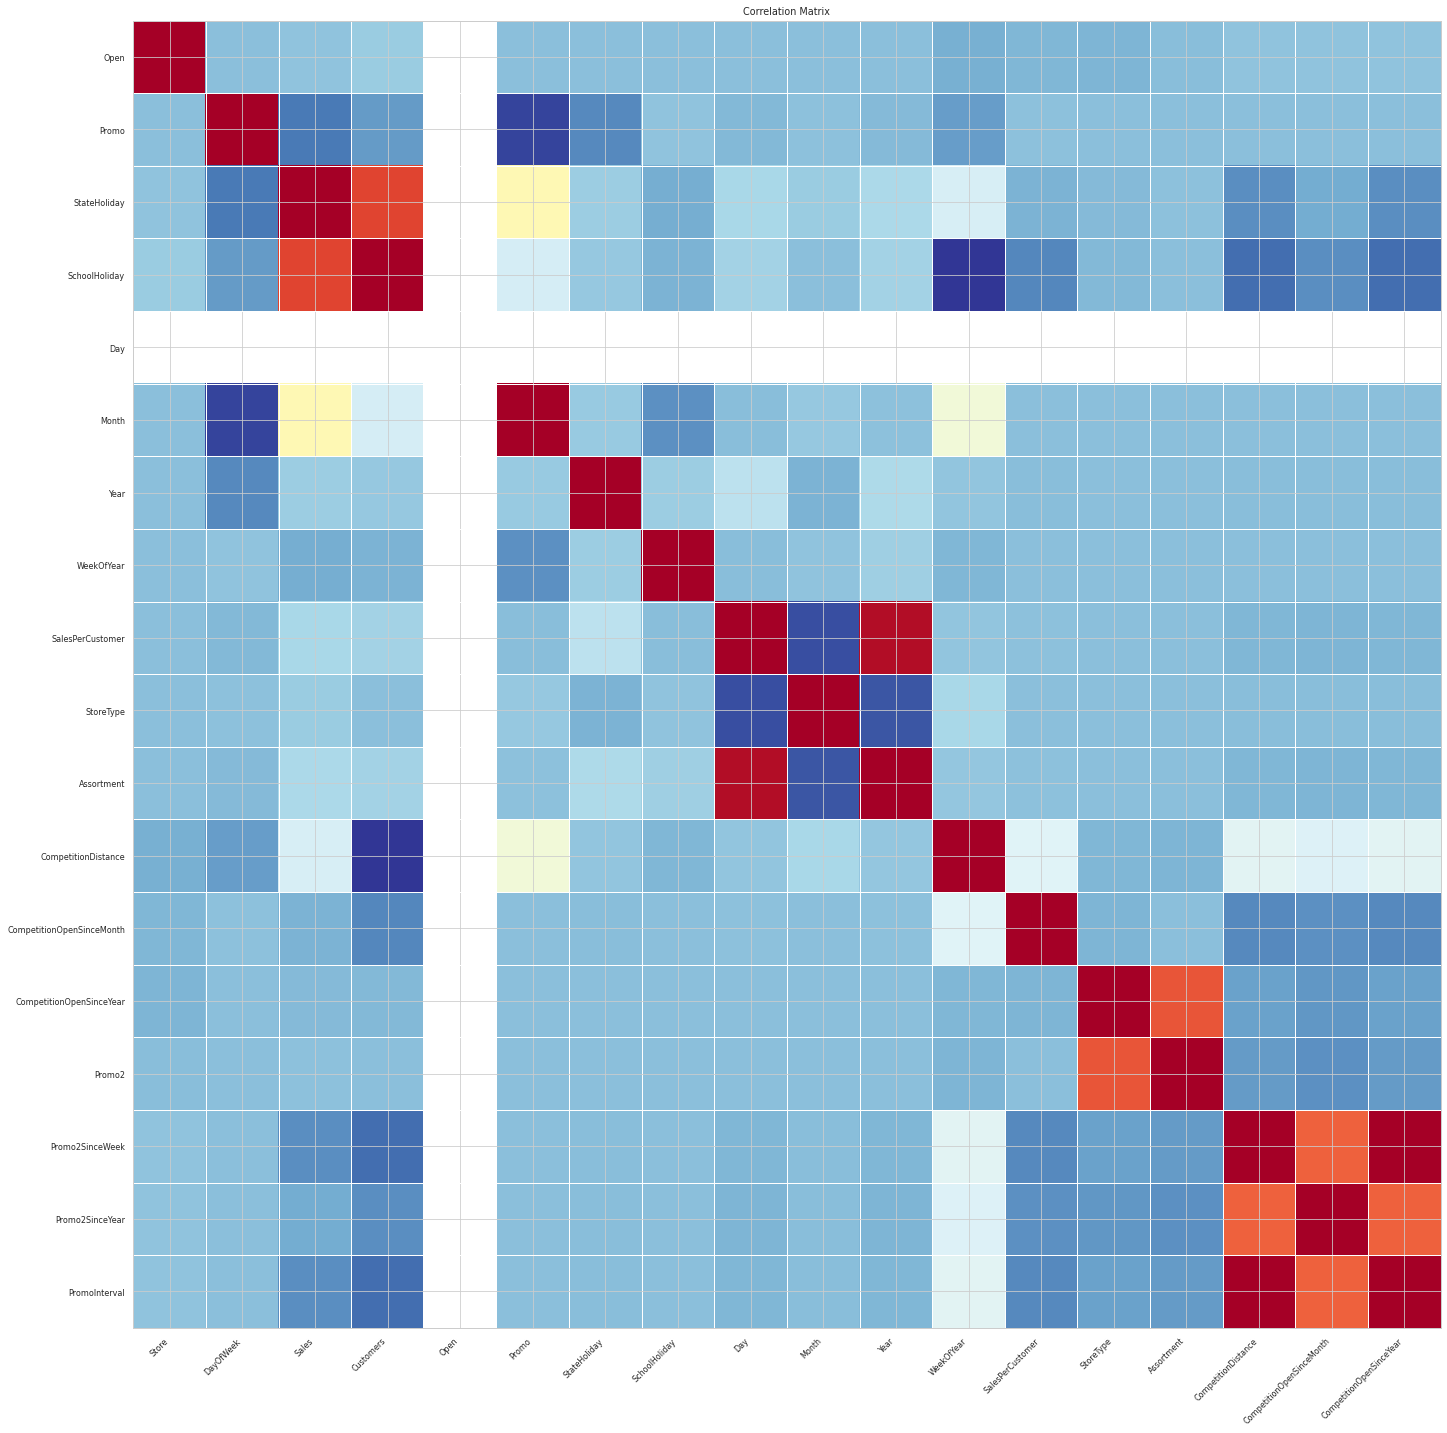

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
sm.graphics.plot_corr(corr_matrix, xnames = train_store.columns, ax =ax)
plt.show()

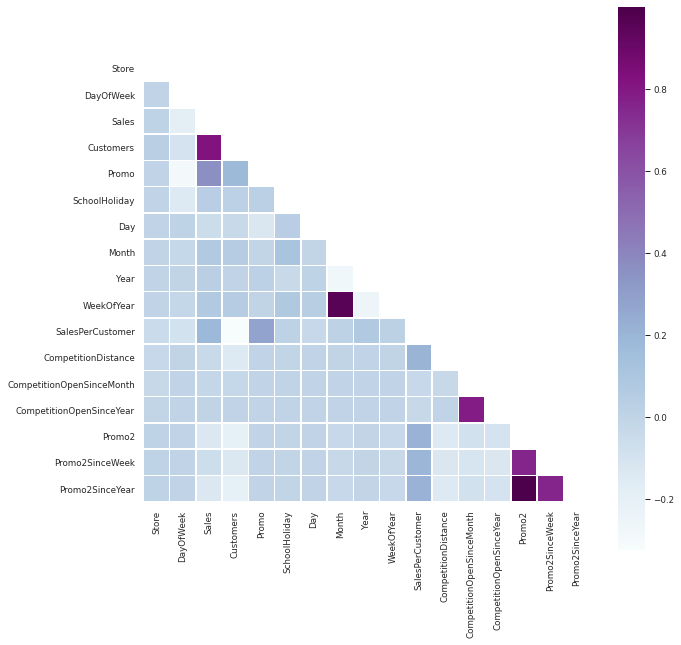

In [ ]:
correlation_ = train_store.drop('Open', axis=1).corr()

# Mask for visualization 
mask= np.zeros_like(correlation_, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot Graph 

fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(correlation_, mask = mask, square=True, cmap = "BuPu", linewidths=.5, ax=ax)


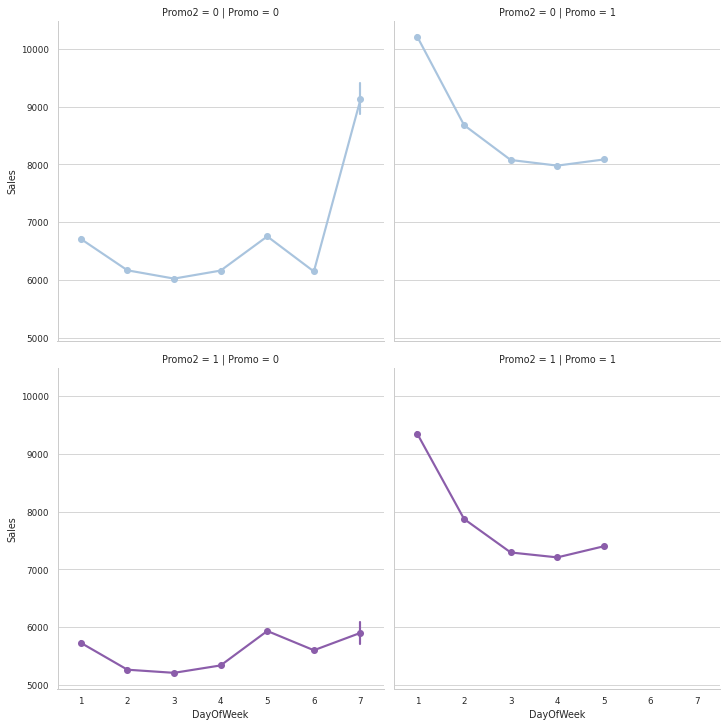

In [ ]:
sns.factorplot(data= train_store, x="DayOfWeek", y="Sales",
               col = 'Promo',
               palette = "BuPu",
               row= 'Promo2',
               hue= 'Promo2')

### 3. Time-Series Analysis

on StoreType

assuming:
- Store number 2 for StoreType A
- Store number 85 for StoreType B,
- Store number 1 for StoreType C
- Store number 13 for StoreType D.



#### 3.1 Seasonality

In [ ]:
# preparation: input should be float type
train['Sales'] = train['Sales'] * 1.0

# store types
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True) # solve the reverse order
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']


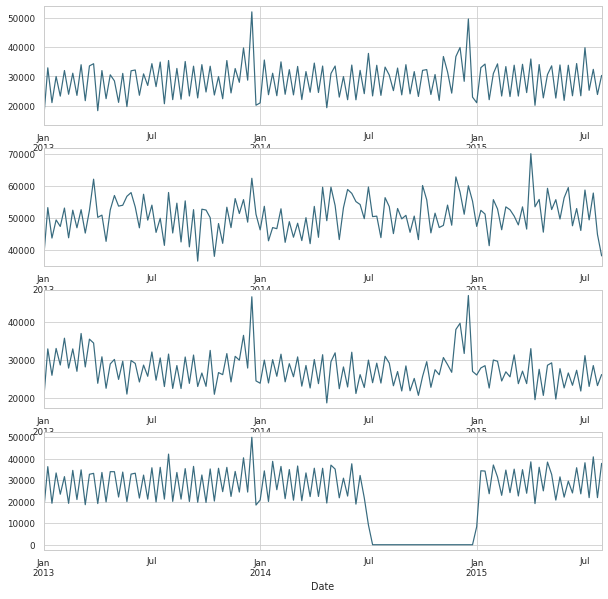

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(10,10))

sales_a.resample('W').sum().plot(color = c, ax = ax1)
sales_b.resample('W').sum().plot(color = c, ax = ax2)
sales_c.resample('W').sum().plot(color = c, ax = ax3)
sales_d.resample('W').sum().plot(color = c, ax = ax4)

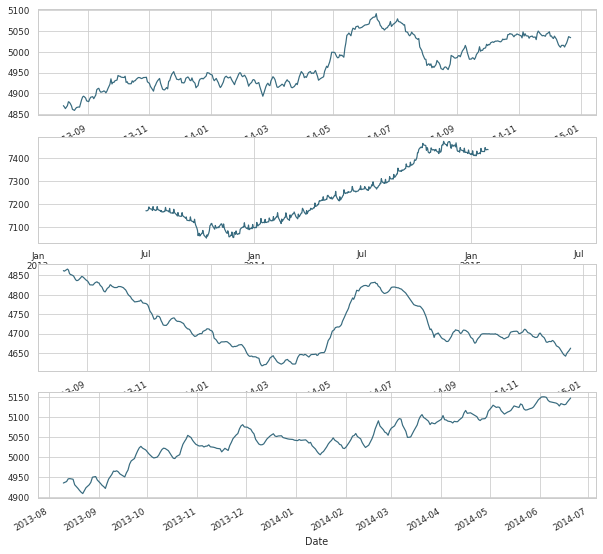

In [ ]:
# yearly trend

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(10,10))

#monthly

decomposition_a = seasonal_decompose(sales_a, model='additive', freq = 365)
decomposition_a.trend.plot(color=c, ax=ax1)

decomposition_b = seasonal_decompose(sales_b, model='additive', freq= 365,)
decomposition_b.trend.plot(color=c, ax=ax2)

decomposition_c = seasonal_decompose(sales_c, model = 'additive', freq = 365)
decomposition_c.trend.plot(color = c, ax = ax3)

decomposition_d = seasonal_decompose(sales_d, model = 'additive', freq = 365)
decomposition_d.trend.plot(color = c, ax = ax4)

### 4. Prophet

- Facebooks Prophet for time-series forecasting




In [ ]:
df = pd.read_csv(path_main/'train.csv', low_memory=False)

df = df[(df.Sales != 0) & (df.Open != 0)]

sales = df[df.Store == 12].loc[:,['Sales', 'Date']]

sales.head()

,Sales,Date
11,8959,2015-07-31
1126,7996,2015-07-30
2241,9236,2015-07-29
3356,8822,2015-07-28
4471,10227,2015-07-27


In [ ]:
sales = sales.sort_index(ascending=False)
sales['Date'] = pd.DatetimeIndex(sales.Date)
sales.dtypes

sales = sales.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})


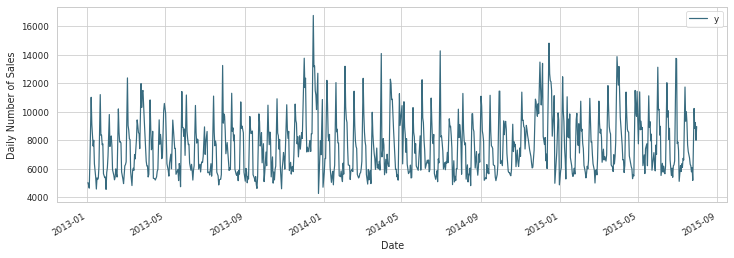

In [ ]:
ax = sales.set_index('ds').plot(figsize = (12, 4), color = c)
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

In [ ]:
state_dates = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & (df.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))      
holidays.head()

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04


In [ ]:
# create model and train

m = Prophet(holidays=holidays, growth='linear',
            interval_width=0.95, # set 
            )
m.fit(sales)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# create future df
future = m.make_future_dataframe(periods=7)
future.tail()

,ds
786,2015-08-03
787,2015-08-04
788,2015-08-05
789,2015-08-06
790,2015-08-07


In [ ]:
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,school_holiday,school_holiday_lower,school_holiday_upper,state_holiday,state_holiday_lower,state_holiday_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-02,6729.841593,4110.866034,10642.787071,6729.841593,6729.841593,640.312264,640.312264,640.312264,639.511945,639.511945,639.511945,639.511945,639.511945,639.511945,0.0,0.0,0.0,60.036316,60.036316,60.036316,-59.235997,-59.235997,-59.235997,0.0,0.0,0.0,7370.153858
1,2013-01-03,6730.698971,3645.116673,10393.557554,6730.698971,6730.698971,349.494782,349.494782,349.494782,639.511945,639.511945,639.511945,639.511945,639.511945,639.511945,0.0,0.0,0.0,-157.163812,-157.163812,-157.163812,-132.853351,-132.853351,-132.853351,0.0,0.0,0.0,7080.193752
2,2013-01-04,6731.556348,3653.180267,10541.518027,6731.556348,6731.556348,244.445282,244.445282,244.445282,639.511945,639.511945,639.511945,639.511945,639.511945,639.511945,0.0,0.0,0.0,-202.708160,-202.708160,-202.708160,-192.358504,-192.358504,-192.358504,0.0,0.0,0.0,6976.001629
3,2013-01-05,6732.413725,2962.736273,9668.982779,6732.413725,6732.413725,-456.511031,-456.511031,-456.511031,639.511945,639.511945,639.511945,639.511945,639.511945,639.511945,0.0,0.0,0.0,-857.859854,-857.859854,-857.859854,-238.163122,-238.163122,-238.163122,0.0,0.0,0.0,6275.902694
4,2013-01-07,6734.128479,5696.550974,12222.452486,6734.128479,6734.128479,2034.542512,2034.542512,2034.542512,639.511945,639.511945,639.511945,639.511945,639.511945,639.511945,0.0,0.0,0.0,1686.568403,1686.568403,1686.568403,-291.537836,-291.537836,-291.537836,0.0,0.0,0.0,8768.670991


In [ ]:
fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat' })
fc.head()

,ds,yhat
0,2013-01-02,7370.153858
1,2013-01-03,7080.193752
2,2013-01-04,6976.001629
3,2013-01-05,6275.902694
4,2013-01-07,8768.670991


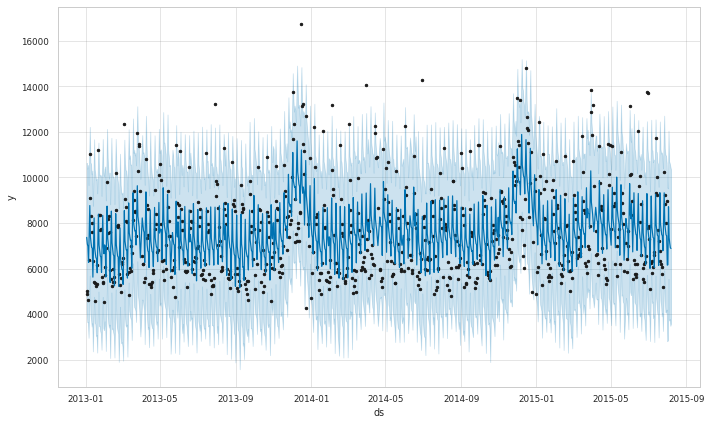

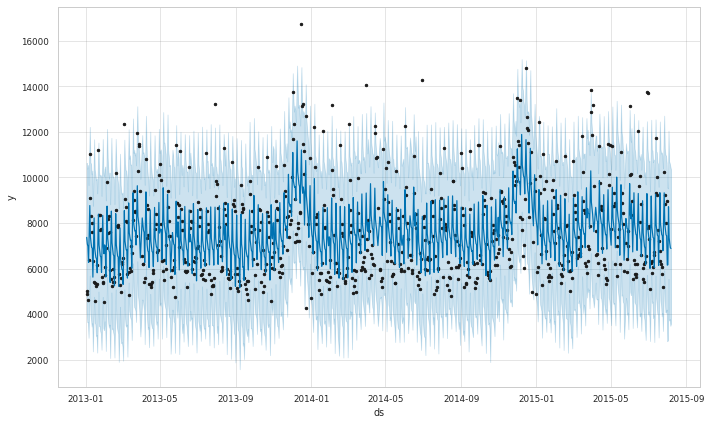

In [ ]:
m.plot(forecast)

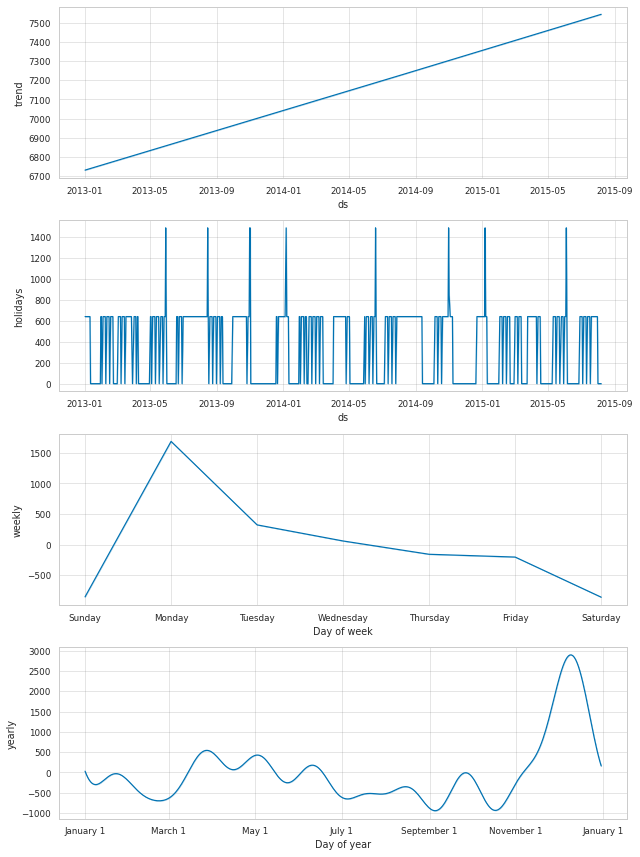

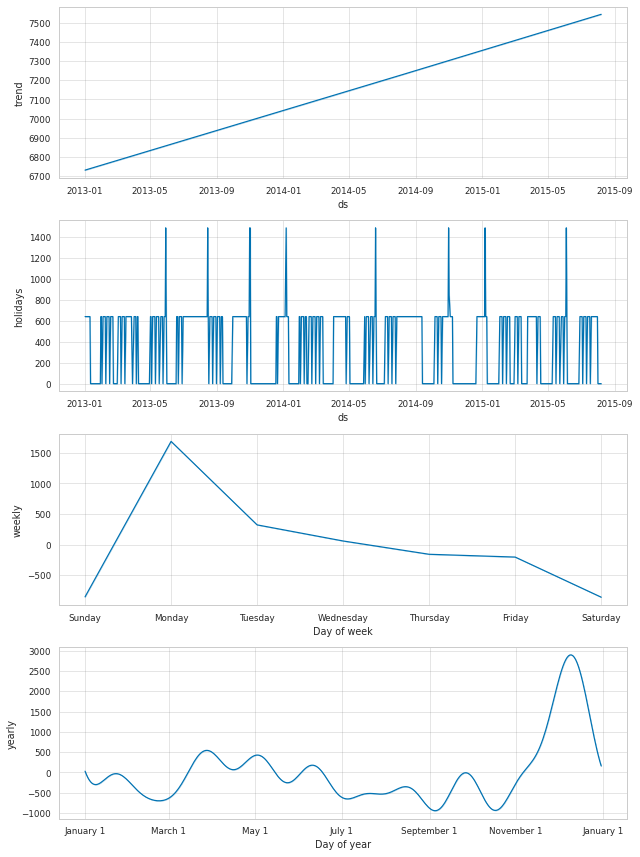

In [ ]:
m.plot_components(forecast)

In [ ]:
help(Prophet)

In [ ]:
import plotly
import notebook
import ipywidgets 
from fbprophet.plot import plot_plotly, plot_components_plotly

In [ ]:
plot_plotly(m, forecast)

In [ ]:
plot_components_plotly(m, forecast)

## 3. Fastai

In [ ]:
PATH = path_main

In [ ]:
table_names = ['train', 'store', 'store_states', 'state_names', 'googletrend', 'weather', 'test']

In [ ]:
tables = [pd.read_csv(PATH/f'{fname}.csv', low_memory=False) for fname in table_names]
train, store, store_states, state_names, googletrend, weather, test = tables
# googletrend.tail()

,file,week,trend
2067,Rossmann_DE_SL,2015-08-30 - 2015-09-05,95
2068,Rossmann_DE_SL,2015-09-06 - 2015-09-12,47
2069,Rossmann_DE_SL,2015-09-13 - 2015-09-19,80
2070,Rossmann_DE_SL,2015-09-20 - 2015-09-26,57
2071,Rossmann_DE_SL,2015-09-27 - 2015-10-03,0


In [ ]:
len(train), len(test)

(1017209, 41088)

SyntaxError: ignored

### 3.1 Data Preparation

#### 3.1.1 Data Extraction and Merge tables

In [ ]:
# turn into booleans
train.StateHoliday = train.StateHoliday != '0'

test.StateHoliday = test.StateHoliday != '0'

In [ ]:
# custom merge function
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if(right_on is None):
        right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, suffixes=("", suffix))

In [ ]:
weather = join_df(weather, state_names, "file", "StateName" )

In [ ]:
# eaxtract Date and State in GoogleTrend and replace HI
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]

googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'

In [ ]:
# custom function to extract Data from datetime fields

def add_datepart(df, fldname, drop=True, time=False):
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64
    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, 
                                           infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 
            'Dayofyear', 'Is_month_end', 'Is_month_start', 
            'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 
            'Is_year_start']
    if time: 
        attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr:
        df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop :
        df.drop(fldname, axis=1, inplace=True)

In [ ]:
add_datepart(weather, "Date", drop=False)
add_datepart(googletrend, "Date", drop=False)
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)

In [ ]:
trend_germany = googletrend[googletrend.file == "Rossmann_DE"]

In [ ]:
store = join_df(store, store_states, "Store")
len(store[store.State.isnull()])

0

In [ ]:
combined  = join_df(train, store, "Store")
combined_test = join_df(test, store, "Store")
len(combined[combined.StoreType.isnull()]), len(combined_test[combined_test.StoreType.isnull()])

(0, 0)

In [ ]:
combined  = join_df(combined, googletrend, ["State", "Year", "Week"])
combined_test = join_df(combined_test, googletrend, ["State", "Year", "Week"])
len(combined[combined.trend.isnull()]), len(combined_test[combined_test.trend.isnull()])

(0, 0)

In [ ]:
combined = combined.merge(trend_germany, 'left', ["Year", "Week"], suffixes=('', '_DE'))
combined_test = combined_test.merge(trend_germany, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(combined[combined.trend_DE.isnull()]),len(combined_test[combined_test.trend_DE.isnull()])

(0, 0)

In [ ]:
combined.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day',
       'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start',
       'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start',
       'Elapsed', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'State', 'file',
       'week', 'trend', 'Date_y', 'Month_y', 'Day_y', 'Dayofweek_y',
       'Dayofyear_y', 'Is_month_end_y', 'Is_month_start_y', 'Is_quarter_end_y',
       'Is_quarter_start_y', 'Is_year_end_y', 'Is_year_start_y', 'Elapsed_y',
       'file_DE', 'week_DE', 'trend_DE', 'Date_DE', 'State_DE', 'Month_DE',
       'Day_DE', 'Dayofweek_DE', 'Dayofyear_DE', 'Is_month_end_DE',
       'Is_month_start_DE', 'Is_quarter_end_DE', 'Is_quarter_start_DE',
       'Is_year_end_DE', 'Is_year_start_DE',

In [ ]:
combined = join_df(combined, weather, ["State","Date"])
combined_test = join_df(combined_test, weather, ["State","Date"])
len(combined[combined.Mean_TemperatureC.isnull()]),len(combined_test[combined_test.Mean_TemperatureC.isnull()])

(0, 0)

In [ ]:
combined.columns, len(combined.columns)

(Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
        'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day',
        'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start',
        'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start',
        'Elapsed', 'StoreType', 'Assortment', 'CompetitionDistance',
        'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
        'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'State', 'file',
        'week', 'trend', 'Date_y', 'Month_y', 'Day_y', 'Dayofweek_y',
        'Dayofyear_y', 'Is_month_end_y', 'Is_month_start_y', 'Is_quarter_end_y',
        'Is_quarter_start_y', 'Is_year_end_y', 'Is_year_start_y', 'Elapsed_y',
        'file_DE', 'week_DE', 'trend_DE', 'Date_DE', 'State_DE', 'Month_DE',
        'Day_DE', 'Dayofweek_DE', 'Dayofyear_DE', 'Is_month_end_DE',
        'Is_month_start_DE', 'Is_quarter_end_DE', 'Is_quarter_start_DE',
        'Is_year_end_DE', 'Is_y

In [ ]:
# get rid of duplicate columns

for df in (combined, combined_test):
  for c in df.columns:
    if c.endswith('_y'):
      if c in df.columns:
        df.drop(c, inplace = True , axis=1)

In [ ]:
len(combined.columns)

74

#### 3.1.2 Missing Values

In [ ]:
for df in (combined, combined_test):
    df['CompetitionOpenSinceYear'] = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    df['Promo2SinceYear'] = df.Promo2SinceYear.fillna(1900).astype(np.int32)
    df['Promo2SinceWeek'] = df.Promo2SinceWeek.fillna(1).astype(np.int32)

In [ ]:
# combine openSinceMonth and openSinceYear to Comp.OpenSinceDate and add column Comp.DaysOpen
for df in (combined,combined_test):
    df["CompetitionOpenSince"] = pd.to_datetime(dict(year=df.CompetitionOpenSinceYear, 
                                                     month=df.CompetitionOpenSinceMonth, day=15))
    df["CompetitionDaysOpen"] = df.Date.subtract(df.CompetitionOpenSince).dt.days


In [ ]:
# correct negative (error) values ind new created columns
for df in (combined, combined_test):
    df.loc[df.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
    df.loc[df.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

# add Comp.MonthsOpen and limit to max. 24 months
for df in (combined,combined_test):
    df["CompetitionMonthsOpen"] = df["CompetitionDaysOpen"]//30
    df.loc[df.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
combined.CompetitionMonthsOpen.unique()


In [ ]:
!pip install isoweek

In [ ]:
from isoweek import Week
for df in (combined,combined_test):
    df["Promo2Since"] = pd.to_datetime(df.apply(lambda x: Week(
        x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1))
    df["Promo2Days"] = df.Date.subtract(df["Promo2Since"]).dt.days

In [ ]:
# correct neg. values = 0, year min() = 1990 and max weeks to 25

for df in (combined,combined_test):
    df.loc[df.Promo2Days<0, "Promo2Days"] = 0
    df.loc[df.Promo2SinceYear<1990, "Promo2Days"] = 0
    df["Promo2Weeks"] = df["Promo2Days"]//7
    df.loc[df.Promo2Weeks<0, "Promo2Weeks"] = 0
    df.loc[df.Promo2Weeks>25, "Promo2Weeks"] = 25
    df.Promo2Weeks.unique()

# Add **elapsed time** and calculate **rolling average**

see: https://www.kaggle.com/fanbyprinciple/rossmann-with-fastai-v3#getting-data-from-fastai


In [ ]:
combined.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,State,file,week,trend,file_DE,week_DE,trend_DE,Date_DE,State_DE,Month_DE,Day_DE,Dayofweek_DE,Dayofyear_DE,Is_month_end_DE,Is_month_start_DE,Is_quarter_end_DE,Is_quarter_start_DE,Is_year_end_DE,Is_year_start_DE,Elapsed_DE,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName,CompetitionOpenSince,CompetitionDaysOpen,CompetitionMonthsOpen,Promo2Since,Promo2Days,Promo2Weeks
0,1,5,2015-07-31,5263,555,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,c,a,1270.0,9,2008,0,1,1900,NaN,HE,Rossmann_DE_HE,2015-08-02 - 2015-08-08,85,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,None,8,2,6,214,False,False,False,False,False,False,1438473600,23,16,8,9,6,3,98,54,18,1021,1018,1015,31.0,15.0,10.0,24,11,NaN,0.0,1.0,Fog,13,Hessen,2008-09-15,2510,24,1900-01-01,0,0
1,2,5,2015-07-31,6064,625,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",TH,Rossmann_DE_TH,2015-08-02 - 2015-08-08,80,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,None,8,2,6,214,False,False,False,False,False,False,1438473600,19,13,7,9,6,3,100,62,25,1021,1019,1017,10.0,10.0,10.0,14,11,NaN,0.0,4.0,Fog,309,Thueringen,2007-11-15,2815,24,2010-03-29,1950,25
2,3,5,2015-07-31,8314,821,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",NW,Rossmann_DE_NW,2015-08-02 - 2015-08-08,86,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,None,8,2,6,214,False,False,False,False,False,False,1438473600,21,13,6,10,7,4,100,61,24,1022,1019,1017,31.0,14.0,10.0,14,5,NaN,0.0,2.0,Fog,354,NordrheinWestfalen,2006-12-15,3150,24,2011-04-04,1579,25
3,4,5,2015-07-31,13995,1498,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,c,c,620.0,9,2009,0,1,1900,NaN,BE,Rossmann_DE_BE,2015-08-02 - 2015-08-08,74,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,None,8,2,6,214,False,False,False,False,False,False,1438473600,19,14,9,9,7,4,94,61,30,1019,1017,1014,10.0,10.0,10.0,23,16,NaN,0.0,6.0,NaN,282,Berlin,2009-09-15,2145,24,1900-01-01,0,0
4,5,5,2015-07-31,4822,559,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,a,a,29910.0,4,2015,0,1,1900,NaN,SN,Rossmann_DE_SN,2015-08-02 - 2015-08-08,82,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,None,8,2,6,214,False,False,False,False,False,False,1438473600,20,15,10,8,6,5,82,55,26,1020,1018,1016,10.0,10.0,10.0,14,11,NaN,0.0,4.0,NaN,290,Sachsen,2015-04-15,107,3,1900-01-01,0,0


In [ ]:
joined = combined.copy()
joined_test = combined_test.copy()

In [ ]:
len(joined), len(combined_test)

(1017209, 41088)

In [ ]:
joined.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,State,file,week,trend,file_DE,week_DE,trend_DE,Date_DE,State_DE,Month_DE,Day_DE,Dayofweek_DE,Dayofyear_DE,Is_month_end_DE,Is_month_start_DE,Is_quarter_end_DE,Is_quarter_start_DE,Is_year_end_DE,Is_year_start_DE,Elapsed_DE,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName,CompetitionOpenSince,CompetitionDaysOpen,CompetitionMonthsOpen,Promo2Since,Promo2Days,Promo2Weeks
0,1,5,2015-07-31,5263,555,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,c,a,1270.0,9,2008,0,1,1900,NaN,HE,Rossmann_DE_HE,2015-08-02 - 2015-08-08,85,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,None,8,2,6,214,False,False,False,False,False,False,1438473600,23,16,8,9,6,3,98,54,18,1021,1018,1015,31.0,15.0,10.0,24,11,NaN,0.0,1.0,Fog,13,Hessen,2008-09-15,2510,24,1900-01-01,0,0
1,2,5,2015-07-31,6064,625,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",TH,Rossmann_DE_TH,2015-08-02 - 2015-08-08,80,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,None,8,2,6,214,False,False,False,False,False,False,1438473600,19,13,7,9,6,3,100,62,25,1021,1019,1017,10.0,10.0,10.0,14,11,NaN,0.0,4.0,Fog,309,Thueringen,2007-11-15,2815,24,2010-03-29,1950,25
2,3,5,2015-07-31,8314,821,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",NW,Rossmann_DE_NW,2015-08-02 - 2015-08-08,86,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,None,8,2,6,214,False,False,False,False,False,False,1438473600,21,13,6,10,7,4,100,61,24,1022,1019,1017,31.0,14.0,10.0,14,5,NaN,0.0,2.0,Fog,354,NordrheinWestfalen,2006-12-15,3150,24,2011-04-04,1579,25
3,4,5,2015-07-31,13995,1498,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,c,c,620.0,9,2009,0,1,1900,NaN,BE,Rossmann_DE_BE,2015-08-02 - 2015-08-08,74,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,None,8,2,6,214,False,False,False,False,False,False,1438473600,19,14,9,9,7,4,94,61,30,1019,1017,1014,10.0,10.0,10.0,23,16,NaN,0.0,6.0,NaN,282,Berlin,2009-09-15,2145,24,1900-01-01,0,0
4,5,5,2015-07-31,4822,559,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,a,a,29910.0,4,2015,0,1,1900,NaN,SN,Rossmann_DE_SN,2015-08-02 - 2015-08-08,82,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,None,8,2,6,214,False,False,False,False,False,False,1438473600,20,15,10,8,6,5,82,55,26,1020,1018,1016,10.0,10.0,10.0,14,11,NaN,0.0,4.0,NaN,290,Sachsen,2015-04-15,107,3,1900-01-01,0,0


In [ ]:
train_df = joined.copy()
test_df = joined_test.copy()


In [ ]:
train_df.to_pickle(path_main/'train_df_notfull')
test_df.to_pickle(path_main/'test_df_notfull')

### 3.2 Create and train Model

In [ ]:
from fastai.tabular import *
from fastai.basics import *


In [ ]:
# ### Create smalle test set
# #### Data augmentation 
# (Cat. and Continuous variables, 
# Categorify(), FillMissing() and Normalize() from fastai libary )

# ### Full train& test set
# #### Data augmentation 
# (Cat. and Continuous variables, 
# Categorify(), FillMissing() and Normalize() from fastai libary )

# create df = train_df[cat_vars + cont_vars + [dep_var, 'Date']].copy()

# create Valid_df (same length as test_set)

# ### Fastai Databunch

# ### Model tabular_learner(data, layers=[100,500], ps=, emb_drop=0.4, y_range = , metrics=exp_rmspe)

SyntaxError: ignored

In [ ]:
# define categorical and continuous variables

# since not full data extraction
missing_cols = ['StateHoliday_fw', 'AfterStateHoliday', 'SchoolHoliday_bw', 'SchoolHoliday_fw', 
 'Promo_bw', 'BeforeStateHoliday', 'Promo_fw', 'StateHoliday_bw']

cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events',]

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',  'Promo', 'SchoolHoliday']
dep_var = 'Sales'

In [ ]:
# create df

df = train_df[cat_vars + cont_vars + [dep_var, 'Date']].copy()

In [ ]:
# create get list for valid set with same length as test set from train_df

test_df['Date'].min(), test_df.Date.max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [ ]:
cut_idx_max = train_df['Date'][(train_df.Date == train_df['Date'][len(test_df)])].index.max()

valid_idx = range(cut_idx_max)
valid_idx

range(0, 41254)

In [ ]:
# check labels (target = 'Sales')
df[dep_var] = df[dep_var] * 1.0 # need float
df.shape

(1017209, 32)

In [ ]:
# define data Augmentation
procs = [FillMissing, Categorify, Normalize]


#### 3.2.2 Create Databunch for Learner

In [ ]:
# empty lr_find() plot and no training
# - y_range and log possible culprit
# without label / .add_test/

data = (TabularList.from_df(df, path= path_main,
                            cat_names = cat_vars,
                            cont_names = cont_vars,
                            procs= procs,).split_by_idx(valid_idx)
                            .label_from_df(cols=dep_var, 
                                           label_cls=FloatList, 
                                          #  log=True
                                           )
                            .add_test(TabularList.from_df(test_df, 
                                                          path=path_main, 
                                                          cat_names =cat_vars,
                                                          cont_names=cont_vars))
                            .databunch()
)

In [ ]:
data.show_batch()

Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,PromoInterval,CompetitionOpenSinceYear,Promo2SinceYear,State,Week,Events,CompetitionDistance_na,CloudCover_na,CompetitionDistance,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,Promo,SchoolHoliday,target
186,4,2013,1,10,False,15,0,a,a,"Jan,Apr,Jul,Oct",2011,2014,BY,2,Rain-Snow,False,False,-0.6658,-1.1949,-1.0858,-0.7200,0.8632,1.5759,1.8602,0.0423,0.6942,0.8794,-1.5075,-1.5828,1.2760,-0.4566,3400.0
482,6,2014,7,5,False,24,0,c,a,#na#,2005,1900,ST,27,Rain-Thunderstorm,False,False,-0.3727,1.8381,1.8911,1.8099,-2.6804,-1.5709,-0.9013,-0.1818,-0.9972,1.4990,0.5768,-0.3903,-0.7837,-0.4566,7313.0
756,3,2013,1,16,False,0,25,a,c,"Jan,Apr,Jul,Oct",1900,2011,NW,3,Snow,False,False,-0.6970,-2.0441,-1.7946,-1.5107,0.7319,1.2689,1.7579,-0.9663,-0.1515,0.8794,-0.8732,-1.0407,-0.7837,-0.4566,10708.0
529,5,2015,3,6,False,24,0,d,c,#na#,2012,1900,SH,10,Rain,False,False,0.9725,-0.5883,-0.3770,-0.4038,-0.0555,0.2711,0.5817,0.0423,-0.1515,0.8794,-0.6919,-0.1735,1.2760,-0.4566,8813.0
97,7,2015,5,10,False,0,0,d,c,#na#,1900,1900,SN,19,Rain,False,False,0.4614,0.2609,0.3318,0.3868,0.8632,-0.4964,-1.0036,0.7148,0.6942,-0.3600,-0.9638,0.1517,-0.7837,-0.4566,0.0


In [ ]:
# since .lr_find() and fit_one_cycle() no results (empty plot / no values) 
# fixed if no np.log() / also changed to metrics = mae
# change to regular y_range ( no np.log()), check for inf values in df. fastai.forum user said this was his problem

# max_log_y = np.log(np.max(train_df['Sales']) *1.2)
max_log_y = np.max(train_df['Sales']) *1.2

y_range = torch.tensor([0, max_log_y], device = defaults.device)
y_range

tensor([    0.0000, 49861.1992])

In [ ]:
learn = tabular_learner(data, 
                        layers=[1000, 500], 
                        ps= [0.001, 0.01], 
                        emb_drop=0.04,
                        y_range = y_range,
                        metrics= mae # change from exp_rmspe
                        )

In [ ]:
# learn.summary()

In [ ]:
learn.lr_find(stop_div=False, num_it=500)

epoch,train_loss,valid_loss,mean_absolute_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


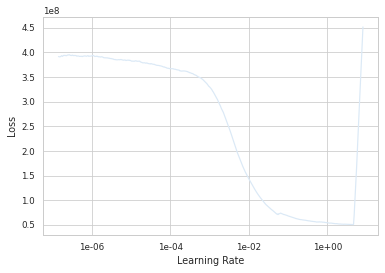

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,mean_absolute_error,time
0,1230473.500000,1526998.750000,867.310791,09:18
1,947137.375000,1298347.500000,771.066772,09:28
2,796686.437500,1151990.500000,706.534607,10:24
3,609603.687500,863967.250000,602.641541,12:16
4,478055.718750,791013.437500,586.742065,13:39


In [ ]:
learn.save('stage1')

In [ ]:
learn.unfreeze()
learn.lr_find()

epoch,train_loss,valid_loss,mean_absolute_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


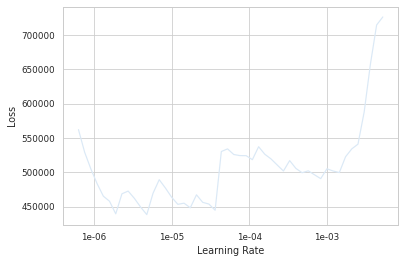

In [ ]:
learn.recorder.plot()

In [ ]:
lr2= 1e-6
learn.fit_one_cycle(5, slice(lr2))

epoch,train_loss,valid_loss,mean_absolute_error,time
0,398008.531250,765812.000000,569.764954,10:06
1,430759.656250,793273.125000,581.637634,10:06
2,448318.437500,764299.437500,565.361572,09:40
3,413151.687500,781228.000000,578.453674,09:35
4,378733.937500,776782.187500,576.090515,09:40


In [ ]:
learn.save('stage2')

In [ ]:
#### 3.4 Predictions

test_preds = learn.get_preds(DatasetType.Test)
test_preds[0].data

tensor([[ 4281.4795],
        [ 6922.9253],
        [ 8434.1475],
        ...,
        [ 6683.2539],
        [25573.4453],
        [ 6629.9761]])

In [ ]:

test_df['Sales'] = test_preds[0].data.numpy().T[0]
test_df[['Id', 'Sales']] = test_df[['Id', 'Sales']].astype(int)

test_df.Sales.dtype


In [ ]:
test_df[["Id", "Sales"]].to_csv("rossmann_submission.csv", index=False)


In [ ]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# !pip install kaggle
!chmod 600 /root/.kaggle/kaggle.json

!kaggle competitions list
# !kaggle competitions download -c [COMPETITION]
# !kaggle competitions submit -c [COMPETITION] -f [FILE] -m [MESSAGE]

# !kaggle datasets list -s [KEYWORD]
# !kaggle datasets download -d [DATASET

Saving kaggle.json to kaggle.json
ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes        108           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        214           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        594           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       3577           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      28993            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge    

In [ ]:
!kaggle competitions submit -c rossmann-store-sales -f rossmann_submission.csv -m "Late submit, testing"

100% 425k/425k [00:00<00:00, 1.97MB/s]
Successfully submitted to Rossmann Store Sales